In [1]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
from transformers import XLNetTokenizer
from datasets import Dataset

# Combine the datasets
fake_df = pd.read_csv('Fake.csv')
true_df = pd.read_csv('True.csv')
fake_df['label'] = 0
true_df['label'] = 1

# Select a subset of the data for quicker processing
fake_df = fake_df.sample(2000)
true_df = true_df.sample(2000)

df = pd.concat([fake_df, true_df]).reset_index(drop=True)

# Preprocess the text
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove all non-word characters
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = text.lower()  # Convert to lowercase
    return text

df['text'] = df['text'].apply(preprocess_text)

# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

# Split the data
X_train, X_val, y_train, y_val = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])

# Tokenize the data
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

train_texts = X_train.tolist()
val_texts = X_val.tolist()

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': y_train.tolist()
})

val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': y_val.tolist()
})


In [3]:
from transformers import XLNetForSequenceClassification, Trainer, TrainingArguments

# Set the environment variable to disable WandB
import os
os.environ["WANDB_DISABLED"] = "true"

# Load the model
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=2)

# Define training arguments with early stopping
training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=3,              
    per_device_train_batch_size=8,  
    per_device_eval_batch_size=8,   
    warmup_steps=500,                
    weight_decay=0.01,               
    logging_dir='./logs',            
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False
)

# Initialize Trainer
trainer = Trainer(
    model=model,                        
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

# Train the model
trainer.train()


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/1200 [00:00<?, ?it/s]

{'loss': 0.8005, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.03}
{'loss': 0.7221, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.05}
{'loss': 0.6619, 'learning_rate': 3e-06, 'epoch': 0.07}
{'loss': 0.7423, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.1}
{'loss': 0.6613, 'learning_rate': 5e-06, 'epoch': 0.12}
{'loss': 0.627, 'learning_rate': 6e-06, 'epoch': 0.15}
{'loss': 0.4922, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.17}
{'loss': 0.455, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.2}
{'loss': 0.4059, 'learning_rate': 9e-06, 'epoch': 0.23}
{'loss': 0.3004, 'learning_rate': 1e-05, 'epoch': 0.25}
{'loss': 0.2207, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.28}
{'loss': 0.1885, 'learning_rate': 1.2e-05, 'epoch': 0.3}
{'loss': 0.1597, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.33}
{'loss': 0.169, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.35}
{'loss': 0.3231, 'learning_rate': 1.5e-05, 'epoch': 0.38}
{'loss': 0.1729, 'learning_ra

***** Running Evaluation *****
  Num examples = 800
  Batch size = 8


  0%|          | 0/100 [00:00<?, ?it/s]

Saving model checkpoint to ./results\checkpoint-400
Configuration saved in ./results\checkpoint-400\config.json


{'eval_loss': 0.025621023029088974, 'eval_runtime': 1575.3787, 'eval_samples_per_second': 0.508, 'eval_steps_per_second': 0.063, 'epoch': 1.0}


Model weights saved in ./results\checkpoint-400\pytorch_model.bin
tokenizer config file saved in ./results\checkpoint-400\tokenizer_config.json
Special tokens file saved in ./results\checkpoint-400\special_tokens_map.json


{'loss': 0.0001, 'learning_rate': 4.1e-05, 'epoch': 1.02}
{'loss': 0.0002, 'learning_rate': 4.2e-05, 'epoch': 1.05}
{'loss': 0.0, 'learning_rate': 4.3e-05, 'epoch': 1.07}
{'loss': 0.0001, 'learning_rate': 4.4000000000000006e-05, 'epoch': 1.1}
{'loss': 0.0, 'learning_rate': 4.5e-05, 'epoch': 1.12}
{'loss': 0.0, 'learning_rate': 4.600000000000001e-05, 'epoch': 1.15}
{'loss': 0.0, 'learning_rate': 4.7e-05, 'epoch': 1.18}
{'loss': 0.0, 'learning_rate': 4.8e-05, 'epoch': 1.2}
{'loss': 0.0, 'learning_rate': 4.9e-05, 'epoch': 1.23}
{'loss': 0.0, 'learning_rate': 5e-05, 'epoch': 1.25}
{'loss': 0.0, 'learning_rate': 4.928571428571429e-05, 'epoch': 1.27}
{'loss': 0.0, 'learning_rate': 4.8571428571428576e-05, 'epoch': 1.3}
{'loss': 0.0, 'learning_rate': 4.785714285714286e-05, 'epoch': 1.32}
{'loss': 0.0, 'learning_rate': 4.714285714285714e-05, 'epoch': 1.35}
{'loss': 0.1169, 'learning_rate': 4.642857142857143e-05, 'epoch': 1.38}
{'loss': 0.1442, 'learning_rate': 4.5714285714285716e-05, 'epoch': 1

***** Running Evaluation *****
  Num examples = 800
  Batch size = 8


{'loss': 0.1117, 'learning_rate': 2.857142857142857e-05, 'epoch': 2.0}


  0%|          | 0/100 [00:00<?, ?it/s]

Saving model checkpoint to ./results\checkpoint-800
Configuration saved in ./results\checkpoint-800\config.json


{'eval_loss': 0.040492963045835495, 'eval_runtime': 1453.1059, 'eval_samples_per_second': 0.551, 'eval_steps_per_second': 0.069, 'epoch': 2.0}


Model weights saved in ./results\checkpoint-800\pytorch_model.bin
tokenizer config file saved in ./results\checkpoint-800\tokenizer_config.json
Special tokens file saved in ./results\checkpoint-800\special_tokens_map.json


{'loss': 0.0004, 'learning_rate': 2.785714285714286e-05, 'epoch': 2.02}
{'loss': 0.0957, 'learning_rate': 2.714285714285714e-05, 'epoch': 2.05}
{'loss': 0.106, 'learning_rate': 2.642857142857143e-05, 'epoch': 2.08}
{'loss': 0.0003, 'learning_rate': 2.5714285714285714e-05, 'epoch': 2.1}
{'loss': 0.0002, 'learning_rate': 2.5e-05, 'epoch': 2.12}
{'loss': 0.0002, 'learning_rate': 2.4285714285714288e-05, 'epoch': 2.15}
{'loss': 0.0955, 'learning_rate': 2.357142857142857e-05, 'epoch': 2.17}
{'loss': 0.0555, 'learning_rate': 2.2857142857142858e-05, 'epoch': 2.2}
{'loss': 0.0006, 'learning_rate': 2.214285714285714e-05, 'epoch': 2.23}
{'loss': 0.0002, 'learning_rate': 2.1428571428571428e-05, 'epoch': 2.25}
{'loss': 0.0002, 'learning_rate': 2.0714285714285718e-05, 'epoch': 2.27}
{'loss': 0.0001, 'learning_rate': 2e-05, 'epoch': 2.3}
{'loss': 0.0001, 'learning_rate': 1.928571428571429e-05, 'epoch': 2.33}
{'loss': 0.0001, 'learning_rate': 1.8571428571428572e-05, 'epoch': 2.35}
{'loss': 0.0001, 'le

***** Running Evaluation *****
  Num examples = 800
  Batch size = 8


{'loss': 0.0001, 'learning_rate': 0.0, 'epoch': 3.0}


  0%|          | 0/100 [00:00<?, ?it/s]

Saving model checkpoint to ./results\checkpoint-1200
Configuration saved in ./results\checkpoint-1200\config.json


{'eval_loss': 0.008936840109527111, 'eval_runtime': 1454.1905, 'eval_samples_per_second': 0.55, 'eval_steps_per_second': 0.069, 'epoch': 3.0}


Model weights saved in ./results\checkpoint-1200\pytorch_model.bin
tokenizer config file saved in ./results\checkpoint-1200\tokenizer_config.json
Special tokens file saved in ./results\checkpoint-1200\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results\checkpoint-1200 (score: 0.008936840109527111).


{'train_runtime': 48306.3372, 'train_samples_per_second': 0.199, 'train_steps_per_second': 0.025, 'train_loss': 0.09111855497190845, 'epoch': 3.0}


TrainOutput(global_step=1200, training_loss=0.09111855497190845, metrics={'train_runtime': 48306.3372, 'train_samples_per_second': 0.199, 'train_steps_per_second': 0.025, 'train_loss': 0.09111855497190845, 'epoch': 3.0})

In [4]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

# Classification report and confusion matrix
class_report = classification_report(y_val, preds, target_names=['Fake', 'True'])
conf_matrix = confusion_matrix(y_val, preds)

print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)


***** Running Prediction *****
  Num examples = 800
  Batch size = 8


  0%|          | 0/100 [00:00<?, ?it/s]

Classification Report:
               precision    recall  f1-score   support

        Fake       1.00      1.00      1.00       400
        True       1.00      1.00      1.00       400

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800

Confusion Matrix:
 [[400   0]
 [  1 399]]


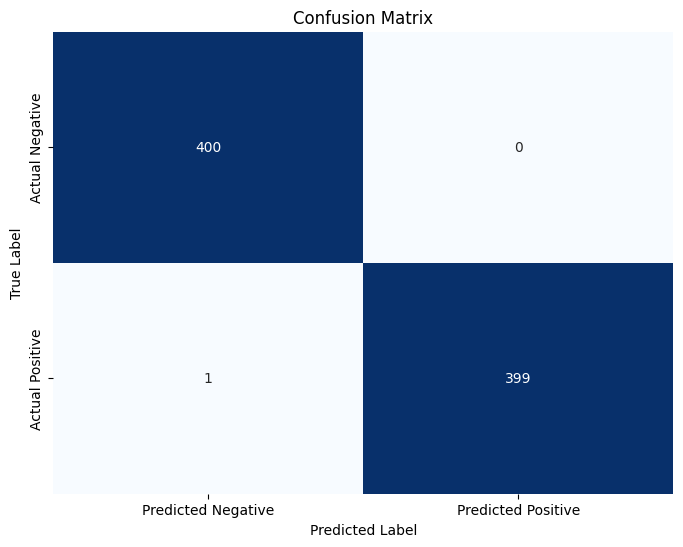

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the confusion matrix
conf_matrix = np.array([[400, 0],
                        [1, 399]])

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])

# Set labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


In [5]:
# Save the model and tokenizer
model.save_pretrained('./saved_model')
tokenizer.save_pretrained('./saved_model')

# Save evaluation metrics
with open('./saved_model/classification_report.txt', 'w') as f:
    f.write(class_report)

np.save('./saved_model/confusion_matrix.npy', conf_matrix)


Configuration saved in ./saved_model\config.json
Model weights saved in ./saved_model\pytorch_model.bin
tokenizer config file saved in ./saved_model\tokenizer_config.json
Special tokens file saved in ./saved_model\special_tokens_map.json


In [6]:
import os
import torch
from transformers import XLNetTokenizer, XLNetForSequenceClassification

# Load the saved model and tokenizer
model_path = './saved_model'
tokenizer = XLNetTokenizer.from_pretrained(model_path)
model = XLNetForSequenceClassification.from_pretrained(model_path)

# Ensure the model is in evaluation mode
model.eval()

# Define a function to preprocess the input text
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove all non-word characters
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = text.lower()  # Convert to lowercase
    return text

# Define a function to predict the label of a single input text
def predict(text):
    # Preprocess the text
    preprocessed_text = preprocess_text(text)
    
    # Tokenize the text
    inputs = tokenizer(preprocessed_text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class_id = torch.argmax(logits, dim=-1).item()
        
    # Map the predicted class id to the label
    label_map = {0: 'Fake', 1: 'True'}
    predicted_label = label_map[predicted_class_id]
    
    return predicted_label

# Example input text
input_text = "This is an example input text to classify."

# Get the prediction
predicted_label = predict(input_text)

print(f"The predicted label for the input text is: {predicted_label}")


Didn't find file ./saved_model\added_tokens.json. We won't load it.
loading file ./saved_model\spiece.model
loading file None
loading file ./saved_model\special_tokens_map.json
loading file ./saved_model\tokenizer_config.json
loading configuration file ./saved_model\config.json
Model config XLNetConfig {
  "_name_or_path": "xlnet-base-cased",
  "architectures": [
    "XLNetForSequenceClassification"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "mem_len": null,
  "model_type": "xlnet",
  "n_head": 12,
  "n_layer": 12,
  "pad_token_id": 5,
  "problem_type": "single_label_classification",
  "reuse_len": null,
  "same_length": false,
  "start_n_top": 5,
  "summary_activation": "tanh",
  "summary_last_dropout": 0.1,
  "summary_type": "last",
  "summary_use_pr

The predicted label for the input text is: Fake


In [18]:
import os
import torch
import re
from transformers import XLNetTokenizer, XLNetForSequenceClassification
import shap
import numpy as np

# Load the saved model and tokenizer
model_path = './saved_model'
tokenizer = XLNetTokenizer.from_pretrained(model_path)
model = XLNetForSequenceClassification.from_pretrained(model_path)

# Ensure the model is in evaluation mode
model.eval()

# Define a function to preprocess the input text
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove all non-word characters
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = text.lower()  # Convert to lowercase
    return text

# Define a function to tokenize and pad the text
def tokenize_and_pad(texts):
    tokenized_texts = [tokenizer(preprocess_text(text), return_tensors='pt', truncation=True, padding='max_length', max_length=512) for text in texts]
    input_ids = torch.cat([t['input_ids'] for t in tokenized_texts], dim=0)
    attention_masks = torch.cat([t['attention_mask'] for t in tokenized_texts], dim=0)
    return {'input_ids': input_ids, 'attention_mask': attention_masks}

# Define a custom prediction function for SHAP
def custom_predict(texts):
    inputs = tokenize_and_pad(texts)
    with torch.no_grad():
        outputs = model(**inputs)
        return torch.nn.functional.softmax(outputs.logits, dim=1).cpu().numpy()

# Example input text
input_text = "This is an example input text to classify."

# Tokenize the input text
tokenized_input = tokenize_and_pad([input_text])

# Predict the label
with torch.no_grad():
    outputs = model(**tokenized_input)
    prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]
    predicted_label = 'True' if prediction == 1 else 'Fake'
    print(f"The predicted label for the input text is: {predicted_label}")

# Wrap the model to work with SHAP
class WrappedModel:
    def __init__(self, model):
        self.model = model
    
    def predict(self, texts):
        inputs = tokenize_and_pad(texts)
        with torch.no_grad():
            outputs = self.model(**inputs)
            return torch.nn.functional.softmax(outputs.logits, dim=1).cpu().numpy()

wrapped_model = WrappedModel(model)

# Prepare the masker
masker = shap.maskers.Text(tokenizer)

# Use SHAP to explain the prediction
explainer = shap.Explainer(wrapped_model.predict, masker)

# Explain the prediction
shap_values = explainer([input_text])

# Plot the explanation
shap.plots.text(shap_values[0])


Didn't find file ./saved_model\added_tokens.json. We won't load it.
loading file ./saved_model\spiece.model
loading file None
loading file ./saved_model\special_tokens_map.json
loading file ./saved_model\tokenizer_config.json
loading configuration file ./saved_model\config.json
Model config XLNetConfig {
  "_name_or_path": "xlnet-base-cased",
  "architectures": [
    "XLNetForSequenceClassification"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "mem_len": null,
  "model_type": "xlnet",
  "n_head": 12,
  "n_layer": 12,
  "pad_token_id": 5,
  "problem_type": "single_label_classification",
  "reuse_len": null,
  "same_length": false,
  "start_n_top": 5,
  "summary_activation": "tanh",
  "summary_last_dropout": 0.1,
  "summary_type": "last",
  "summary_use_pr

The predicted label for the input text is: Fake


  0%|          | 0/110 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [04:14, 254.93s/it]              


In [29]:
import os
import torch
import re
from transformers import XLNetTokenizer, XLNetForSequenceClassification
import shap
import numpy as np

# Load the saved model and tokenizer
model_path = './saved_model'
tokenizer = XLNetTokenizer.from_pretrained(model_path)
model = XLNetForSequenceClassification.from_pretrained(model_path)

# Ensure the model is in evaluation mode
model.eval()

# Define a function to preprocess the input text
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove all non-word characters
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = text.lower()  # Convert to lowercase
    return text

# Define a function to tokenize and pad the text
def tokenize_and_pad(texts):
    tokenized_texts = [tokenizer(preprocess_text(text), return_tensors='pt', truncation=True, padding='max_length', max_length=128) for text in texts]
    input_ids = torch.cat([t['input_ids'] for t in tokenized_texts], dim=0)
    attention_masks = torch.cat([t['attention_mask'] for t in tokenized_texts], dim=0)
    return {'input_ids': input_ids, 'attention_mask': attention_masks}

# Define a custom prediction function for SHAP
def custom_predict(texts):
    inputs = tokenize_and_pad(texts)
    with torch.no_grad():
        outputs = model(**inputs)
        return torch.nn.functional.softmax(outputs.logits, dim=1).cpu().numpy()

# Example input text
input_text = "Donald Trump spent a good portion of his day at his golf club, marking the 84th day he s done so since taking the oath of office. It must have been a bad game because just "

# Tokenize the input text
tokenized_input = tokenize_and_pad([input_text])

# Predict the label
with torch.no_grad():
    outputs = model(**tokenized_input)
    prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]
    predicted_label = 'True' if prediction == 1 else 'Fake'
    print(f"The predicted label for the input text is: {predicted_label}")

# Wrap the model to work with SHAP
class WrappedModel:
    def __init__(self, model):
        self.model = model
    
    def predict(self, texts):
        inputs = tokenize_and_pad(texts)
        with torch.no_grad():
            outputs = self.model(**inputs)
            return torch.nn.functional.softmax(outputs.logits, dim=1).cpu().numpy()

wrapped_model = WrappedModel(model)

# Prepare the masker
masker = shap.maskers.Text(tokenizer)

# Use SHAP to explain the prediction
explainer = shap.Explainer(wrapped_model.predict, masker, algorithm="partition")

# Explain the prediction
shap_values = explainer([input_text], max_evals=500)

# Plot the explanation
shap.plots.text(shap_values[0])


Didn't find file ./saved_model\added_tokens.json. We won't load it.
loading file ./saved_model\spiece.model
loading file None
loading file ./saved_model\special_tokens_map.json
loading file ./saved_model\tokenizer_config.json
loading configuration file ./saved_model\config.json
Model config XLNetConfig {
  "_name_or_path": "xlnet-base-cased",
  "architectures": [
    "XLNetForSequenceClassification"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "mem_len": null,
  "model_type": "xlnet",
  "n_head": 12,
  "n_layer": 12,
  "pad_token_id": 5,
  "problem_type": "single_label_classification",
  "reuse_len": null,
  "same_length": false,
  "start_n_top": 5,
  "summary_activation": "tanh",
  "summary_last_dropout": 0.1,
  "summary_type": "last",
  "summary_use_pr

The predicted label for the input text is: Fake


  0%|          | 0/498 [00:00<?, ?it/s]




PartitionExplainer explainer: 2it [01:17, 77.79s/it]               


In [32]:
import matplotlib.pyplot as plt
import io
import base64

# Generate a plot
def create_plot():
    plt.figure(figsize=(6, 4))
    x = [1, 2, 3, 4, 5]
    y = [2, 3, 5, 7, 11]
    plt.plot(x, y, marker='o')
    plt.title('Sample Plot')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

# Save the plot to a BytesIO object
def get_base64_plot():
    buffer = io.BytesIO()
    create_plot()
    plt.savefig(buffer, format='png')
    plt.close()
    buffer.seek(0)
    
    # Encode the plot in Base64
    img_base64 = base64.b64encode(buffer.read()).decode('utf-8')
    return img_base64

# Generate the Base64-encoded image
img_base64 = get_base64_plot()

# Create an HTML file to display the image
html_content = f"""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Plot Display</title>
</head>
<body>
    <h1>Plot Display</h1>
    <img src="data:image/png;base64,{img_base64}" alt="Plot">
</body>
</html>
"""

# Save the HTML content to a file
with open('plot_display.html', 'w') as f:
    f.write(html_content)

print("HTML file 'plot_display.html' has been created successfully.")


HTML file 'plot_display.html' has been created successfully.
